Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
import io, os, sys, types
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import pandas_profiling
import plotly.express as px
import matplotlib.pyplot as plt
from functools import *
from pyrsistent import *
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest
from IPython import get_ipython
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

appstate = {}
appstate_history = v()
shell = InteractiveShell.instance()

In [2]:
%run ../script/Code.ipynb

{}


In [3]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [4]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [5]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
# think it's wise to drop the whatever has a lot of missing arguments right at the start if psosible so it doesn't interefer
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv') .drop(['EASE-MENT','APARTMENT NUMBER'],axis=1).dropna()

In [6]:
pd.set_option('display.max_columns', None)  
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,$ - 0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,$ - 0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,$ - 0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,$ - 0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,$ - 0,01/01/2019


In [7]:
# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [8]:
df.shape

(22953, 19)

- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

In [9]:
def fix_df(df):
    # One Family Dwellings
    mask = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'
    df = df[mask]
    #sale price was more than $100 thousand and less than $2 million.
    mask = ((df['SALE_PRICE'] > 1e5) &  (df['SALE_PRICE'] < 2e6))
    df = df[mask]
    
    return df

In [10]:
target          = 'SALE_PRICE'
time_column     = 'SALE_DATE'
categories      = ['BUILDING_CLASS_CATEGORY'  , 'TAX_CLASS_AT_PRESENT',
                   'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE']

df              = fix_df(df)
df[time_column] = pd.to_datetime(df[time_column], infer_datetime_format=True) # 

# If change df rerun 
df_by_time      = df.set_index(time_column)
train           = df_by_time[:'2019-04']
test            = df_by_time['2019-04':]
train_numeric   = train.select_dtypes('number')
test_numeric    = test.select_dtypes('number')

# no need to rerun
features        = train_numeric.columns.drop(target)

In [11]:
train_numeric.columns

Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE'],
      dtype='object')

In [12]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [13]:
def show_summary_statistics(df):
    print('shape:\n\t', df.shape)
    print('head:\n', df.head())

def do_kmeans():
    global train_numeric, test_numeric
    kmeans = KMeans(n_clusters=10, n_jobs=1)
    train_numeric['cluster'] = kmeans.fit_predict(train_numeric[features])
    test_numeric['cluster']  = kmeans.predict(test_numeric[features])

def guess_categorical(df):
    return df.select_dtypes(exclude=["number","bool_"])
    
def encode_setup(df):
    import category_encoders as ce
    df = df[categories]
    encoder = ce.OneHotEncoder(use_cat_names=True)
    encoded = encoder.fit_transform(df[categories])
    return encoded

def one_hot_encoder(df):
    encoded = encode_setup(df)
    assert encoded.shape[0] == df.shape[0]
    df = pd.concat([df,encoded],axis=1, sort=False)
    return df

In [14]:
df = fix_df(df)
df = one_hot_encoder(df)

In [15]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_A8',
       'BUILDING_CLASS_AT_PRESENT_B2', 'BUILDING_CLASS_AT_PRESENT_S0',
       'BUILDING_CLASS_AT_PRESENT_B3', 'BUILDING_CLASS_AT_TIME_OF_S

In [16]:
# changed df to include more information, need to update the state of these variables 
df_by_time      = df.set_index(time_column)
train           = df_by_time[:'2019-04']
test            = df_by_time['2019-04':]
train_numeric   = train.select_dtypes('number')
test_numeric    = test.select_dtypes('number')

In [17]:
train_numeric

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
SALE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,550000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2019-01-01,4,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,200000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,2,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,810000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,3,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,125000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,3,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,620000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30,4,13215,3,11422.0,1.0,0.0,1.0,1478.0,1925.0,1,635000,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-04-30,4,11612,73,11420.0,1.0,0.0,1.0,1280.0,1930.0,1,514000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2019-04-30,4,11808,50,11420.0,1.0,0.0,1.0,1333.0,1945.0,1,635000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [18]:
# create html files of df profile reports
# WriteProfileReport(df, 'df');
# WriteProfileReport(train_numeric, 'train_numeric');

In [19]:
show_summary_statistics(df)

shape:
	 (3151, 46)
head:
      BOROUGH          NEIGHBORHOOD  BUILDING_CLASS_CATEGORY  \
44         3   OCEAN PARKWAY-NORTH  01 ONE FAMILY DWELLINGS   
61         4        QUEENS VILLAGE  01 ONE FAMILY DWELLINGS   
78         2  PELHAM PARKWAY SOUTH  01 ONE FAMILY DWELLINGS   
108        3      FLATBUSH-CENTRAL  01 ONE FAMILY DWELLINGS   
111        3         FLATBUSH-EAST  01 ONE FAMILY DWELLINGS   

    TAX_CLASS_AT_PRESENT  BLOCK  LOT BUILDING_CLASS_AT_PRESENT  \
44                     1   5495  801                        A9   
61                     1   7918   72                        A1   
78                     1   4210   19                        A1   
108                    1   5212   69                        A1   
111                    1   7930  121                        A5   

                  ADDRESS  ZIP_CODE  RESIDENTIAL_UNITS  COMMERCIAL_UNITS  \
44       4832 BAY PARKWAY   11230.0                1.0               0.0   
61     80-23 232ND STREET   11427.0          

In [20]:
def explore_data():
    train.groupby('TAX_CLASS_AT_PRESENT')[target].mean().plot.bar();
    fig1=plt.gcf()
    print(train.columns)
    
    do_kmeans() # update train and test
    
    sns.catplot(x='cluster',y=target, data=train_numeric, kind='bar', color='grey')
    plt.title('Cat plot')
    fig2=plt.gcf()
    
    sns.pairplot(df[['TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]);
    plt.title('Pair Plot')
    fig3=plt.gcf()
    
    return (fig1, fig2, fig3)

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_A8',
       'BUILDING_CLASS_AT_PRESENT_B2', 'BUILDING_CLASS_AT_PRESENT_S0',
       'BUILDING_CLASS_AT_PRESENT_B3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUI

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



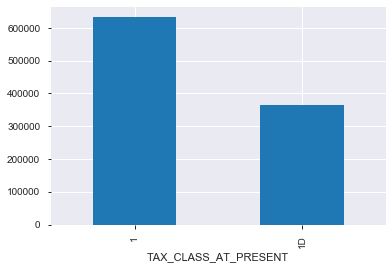

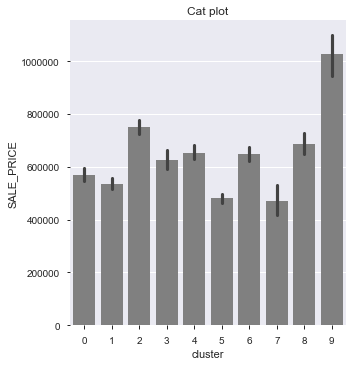

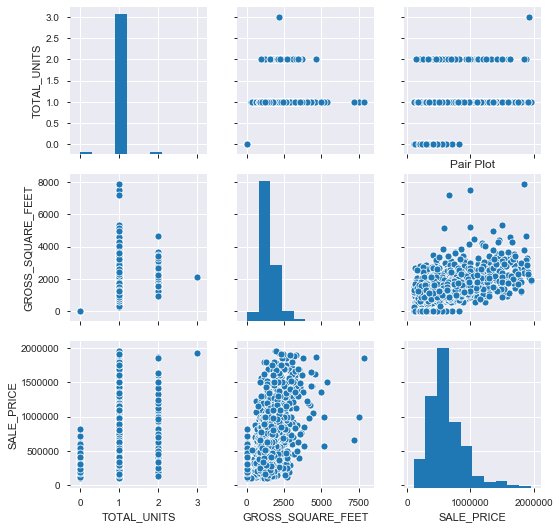

In [21]:
fig, fig2, fig3 = explore_data();

In [22]:
# Looks like a lot of people 
#train['cluster']=df['cluster']
# px.scatter(abc, x='cluster', y=target)

train_numeric = train_numeric
# just looking at numeric features
def get_selector():
    features = train_numeric.columns.drop(target)
    selector = SelectKBest(score_func=f_regression, k=9) # select best 5 predicting features
    features_selected = selector.fit_transform(train_numeric[features], train_numeric[target])
    return {'features_selected':features_selected,
            'selector' : selector}

def run_selector():
    """in order to get the """
    features_selected = selector_info = get_selector()
    selector = selector_info['selector']
    assert selector_info['features_selected'].shape[0] == df.shape[0]
    selected_mask=   selector.get_support()
    _x = train_numeric.drop(target, axis=1)
    return _x.columns[selected_mask]

In [23]:
# select useful features
selected_features = run_selector()
print('Selected Features', run_selector())

Selected Features Index(['BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3', 'cluster'],
      dtype='object')


c:\users\school\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

c:\users\school\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_sele

In [24]:
def do_linear_regression():
    global model
    _target = [target]
    model = LinearRegression()
    model.fit(train_numeric[selected_features],train_numeric[_target])
    model.predict(test_numeric[selected_features])
    
    testMAE = (mean_absolute_error(train_numeric[_target], 
                    model.predict(train_numeric[selected_features])))
    return testMAE

In [25]:
mae = do_linear_regression()

In [26]:
def put_result():
    print(f'''The mean absolute error predicted for the target {target} is ${mae}
                \n  mean of target and test {target} is {df[target].mean()}
                \n  using selected features \n{list(selected_features)}
                \n  predicted via a linear regression model
                \n  features selected using SelectKBest(score_func=f_regression, k=9)
                \n  dataset: NYC_Citywide_Rolling_Calendar_Sales.csv
                ''')

In [27]:
put_result()

The mean absolute error predicted for the target SALE_PRICE is $166711.8648522589
                
  mean of target and test SALE_PRICE is 628560.1126626468
                
  using selected features 
['BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3', 'cluster']
                
  predicted via a linear regression model
                
  features selected using SelectKBest(score_func=f_regression, k=9)
                
  dataset: NYC_Citywide_Rolling_Calendar_Sales.csv
                


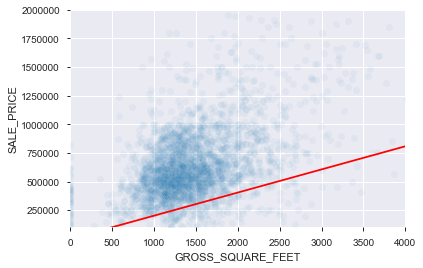

In [28]:
sns.scatterplot(df['GROSS_SQUARE_FEET'], df['SALE_PRICE'], alpha=.05)

plt.xlim(0, 4000)
plt.ylim(1e5, 2e6)
x = np.array(range(5000))
coef_index = list(selected_features).index('GROSS_SQUARE_FEET')
y = x * model.coef_[0, coef_index]

plt.plot(x,y, color='r')

In [29]:
model.coef_

array([[-3.11599592e+01,  2.98609581e+02, -7.80888973e+04,
         5.11884942e+04, -2.69004031e+04,  2.01945852e+02,
         1.07488103e+05,  1.07488103e+05,  8.97112747e+03]])